# Problem Statement

You are provided with historical sales data for 45 stores of a Retail chain located in different
regions. Each store contains a number of departments, and you are tasked with predicting the
department-wide sales for each store.

The data is provided in 4 different CSVs.

In [1]:
# Importing basic packages

import numpy as np
import pandas as pd 
import datetime 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

# Settings
import warnings
warnings.filterwarnings("ignore")

# Loading the dataset  

In [2]:
features=pd.read_csv("features.csv.zip")
stores=pd.read_csv("stores.csv")
train=pd.read_csv("train.csv.zip")
test=pd.read_csv("test.csv.zip")

In [3]:
df_names=['features','stores','train','test']
df_list=[features,stores,train,test]
for i in range(4):
    print('--'*15)
    print(f'Dataframe {df_names[i]} has {df_list[i].shape[0]} rows and {df_list[i].shape[1]} columns.')
    print('--'*15)
    display(df_list[i].head(5))

------------------------------
Dataframe features has 8190 rows and 12 columns.
------------------------------


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


------------------------------
Dataframe stores has 45 rows and 3 columns.
------------------------------


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


------------------------------
Dataframe train has 421570 rows and 5 columns.
------------------------------


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


------------------------------
Dataframe test has 115064 rows and 4 columns.
------------------------------


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [4]:
# Checking the duration of the records

for i in [0,2,3]:
    print(f'Dataframe {df_names[i]} contains data from {df_list[i].Date.min()} to {df_list[i].Date.max()}.\n')

Dataframe features contains data from 2010-02-05 to 2013-07-26.

Dataframe train contains data from 2010-02-05 to 2012-10-26.

Dataframe test contains data from 2012-11-02 to 2013-07-26.



#### Checking for missing values

In [5]:
for i in range(4):
    print(f'Dataframe {df_names[i]} has missing values.\n') if (df_list[i].isna().sum().any()==True) else print(f'Dataframe {df_names[i]} does not have missing values.')

Dataframe features has missing values.

Dataframe stores does not have missing values.
Dataframe train does not have missing values.
Dataframe test does not have missing values.


In [6]:
print('Percentages of missing values in features dataframe.')
(100*features.isna().sum()/features.shape[0]).sort_values()

Percentages of missing values in features dataframe.


Store            0.000000
Date             0.000000
Temperature      0.000000
Fuel_Price       0.000000
IsHoliday        0.000000
CPI              7.142857
Unemployment     7.142857
MarkDown5       50.549451
MarkDown1       50.769231
MarkDown3       55.885226
MarkDown4       57.704518
MarkDown2       64.334554
dtype: float64

All the markdown columns have more than 50 % of data misssing in them. Also, the Markdown data is only available only after November 2011. We'll decide whether to drop them after the EDA.

# EDA

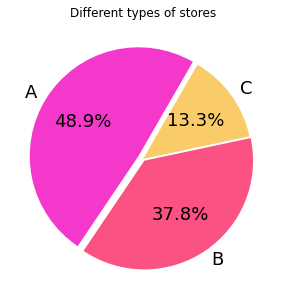

In [7]:
# pie chart
labels = stores.Type.value_counts().index.tolist()
sizes = stores.Type.value_counts().values.tolist()
explode = (0.05, 0.02, 0)
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=60,
        textprops={'fontsize': 18},colors=['#f538cc','#fa5282','#facc69'])
plt.title('Different types of stores');

Almost half of the stores are of type A. Type C stores are least in number.

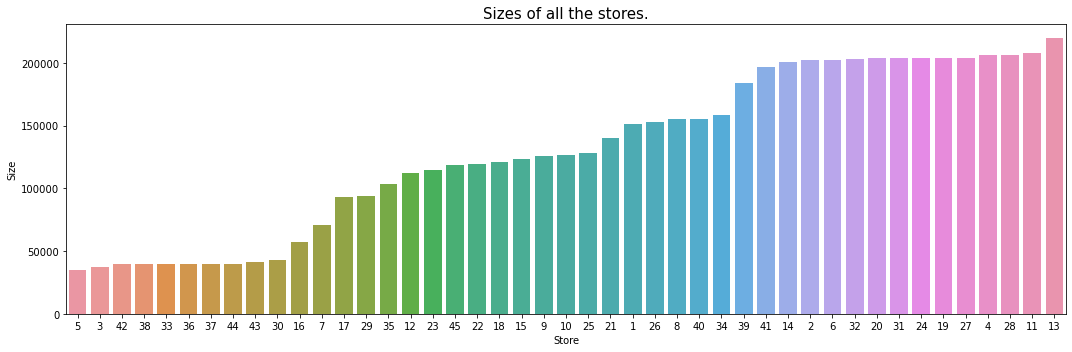

In [8]:
plt.figure(figsize=(15,5))
sns.barplot(x='Store',y='Size',data=stores,order=stores.sort_values('Size')['Store'].tolist())
plt.title('Sizes of all the stores.',fontsize=15)
plt.tight_layout();

Stores are broadly catagorized in 3 categories - Small-sized, Medium-sized, Large-sized. Let's see the relation between size and type of stores.

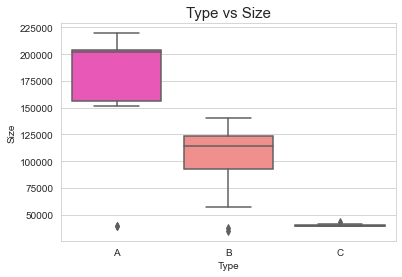

In [9]:
sns.set_style('whitegrid')
sns.boxplot(x='Type',y='Size',data=stores,palette='spring')
plt.title('Type vs Size',fontsize=15);

We can see from the graph that it covers the effect of size column.

In [10]:
# combining train/test and stores and features dataframes for further analysis

train_expanded = train.merge(features, how='inner',on=['Store','Date','IsHoliday']).sort_values(by=
                            ['Store','Dept','Date']).reset_index(drop=True)
train_expanded = train_expanded.merge(stores, how='inner', on=['Store'])

test_expanded = test.merge(features, how='inner',on=['Store','Date','IsHoliday']).sort_values(by=
                            ['Store','Dept','Date']).reset_index(drop=True)
test_expanded = test_expanded.merge(stores, how='inner', on=['Store'])

# converting dtype of date column
train_expanded['Date'] = pd.to_datetime(train_expanded['Date'])
test_expanded['Date'] = pd.to_datetime(test_expanded['Date'])

In [11]:
train_expanded.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


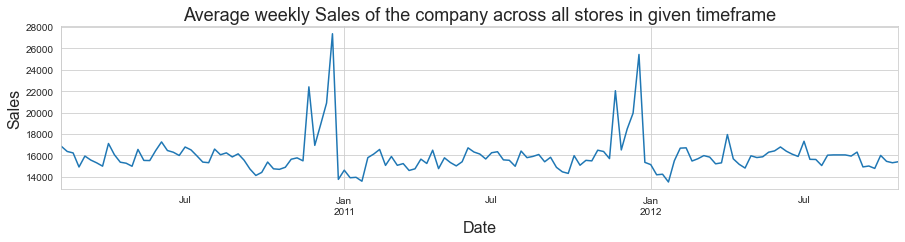

In [12]:
plt.figure(figsize=(15,3))
train_expanded.groupby('Date')['Weekly_Sales'].mean().plot()
plt.title('Average weekly Sales of the company across all stores in given timeframe', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16);

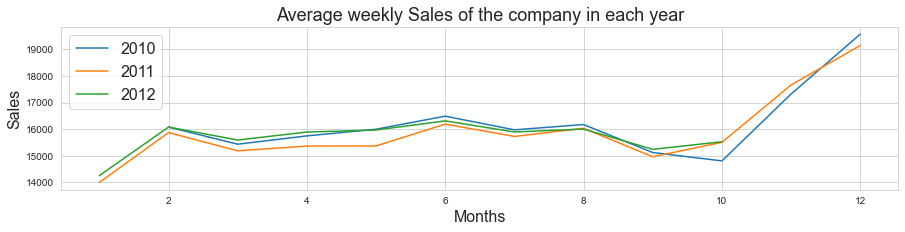

In [13]:
# creating 3 new features from date column

for df in [train_expanded,test_expanded]:
    df['Week'] = df['Date'].dt.week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

plt.figure(figsize=(15,3))
train_expanded[train_expanded['Year']==2010].groupby('Month').mean()['Weekly_Sales'].plot()
train_expanded[train_expanded['Year']==2011].groupby('Month').mean()['Weekly_Sales'].plot()
train_expanded[train_expanded['Year']==2012].groupby('Month').mean()['Weekly_Sales'].plot()
plt.title('Average weekly Sales of the company in each year', fontsize=18)
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Months', fontsize=16);

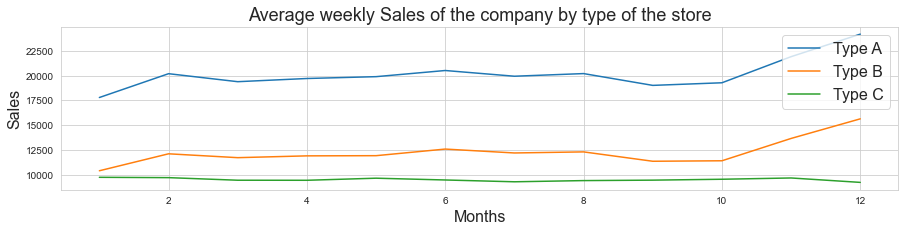

In [14]:
plt.figure(figsize=(15,3))
train_expanded[train_expanded['Type']=='A'].groupby('Month').mean()['Weekly_Sales'].plot()
train_expanded[train_expanded['Type']=='B'].groupby('Month').mean()['Weekly_Sales'].plot()
train_expanded[train_expanded['Type']=='C'].groupby('Month').mean()['Weekly_Sales'].plot()
plt.title('Average weekly Sales of the company by type of the store', fontsize=18)
plt.legend(['Type A', 'Type B', 'Type C'], loc='best', fontsize=16)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Months', fontsize=16);

Sales of the company rise during the end of the year. Possible reasons could be any tradition or festival in that company.

Type A stores seem to have comparitively high sales. But this can be due to difference in number of stores of different type. Also, we can notice that sales of type C are constant over the year.

IsHoliday vs Weekly_Sales


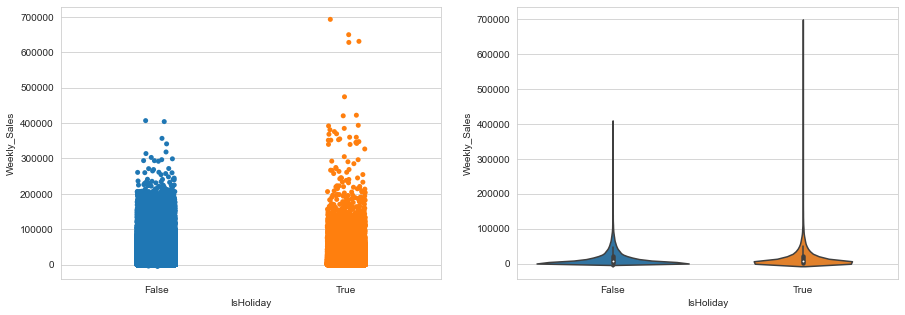

In [15]:
print('IsHoliday vs Weekly_Sales')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.stripplot(y=train_expanded['Weekly_Sales'],x=train_expanded['IsHoliday'])
plt.subplot(1,2,2)
sns.violinplot(y=train_expanded['Weekly_Sales'],x=train_expanded['IsHoliday']);

Highest sales events were recorded in the special holiday week.

Type vs Weekly_Sales


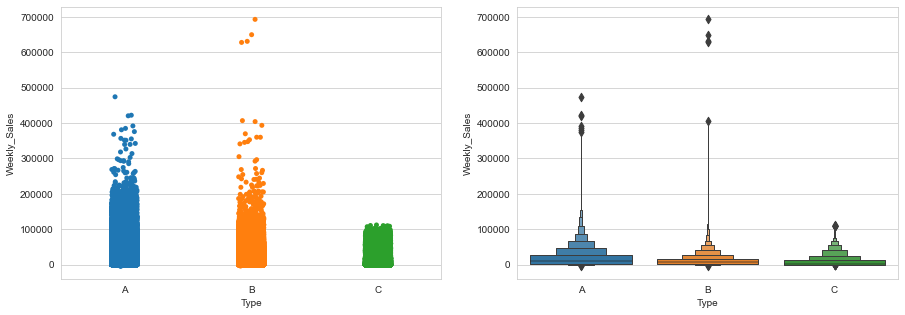

In [16]:
print('Type vs Weekly_Sales')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.stripplot(y=train_expanded['Weekly_Sales'],x=train_expanded['Type'])
plt.subplot(1,2,2)
sns.boxenplot(y=train_expanded['Weekly_Sales'],x=train_expanded['Type']);

Highest sales events were recorded in the type B stores.

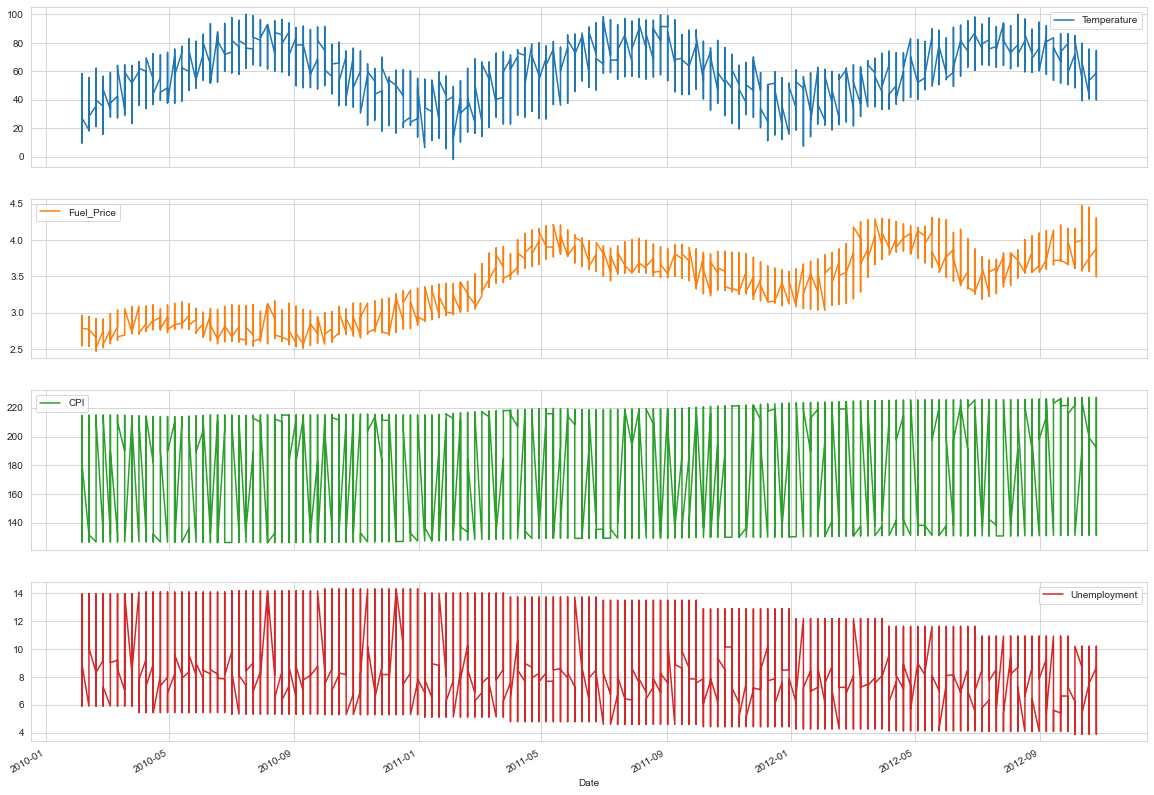

In [17]:
train_expanded[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].plot(x='Date', subplots=True, figsize=(20,15));

As expected, temperature has high seasonality. Week and month column can effectively cover its effect.

Fuel price and CPI show an upward trend and unemployment shows downward trend.

Let's explore effect of these feature with weekly sales.

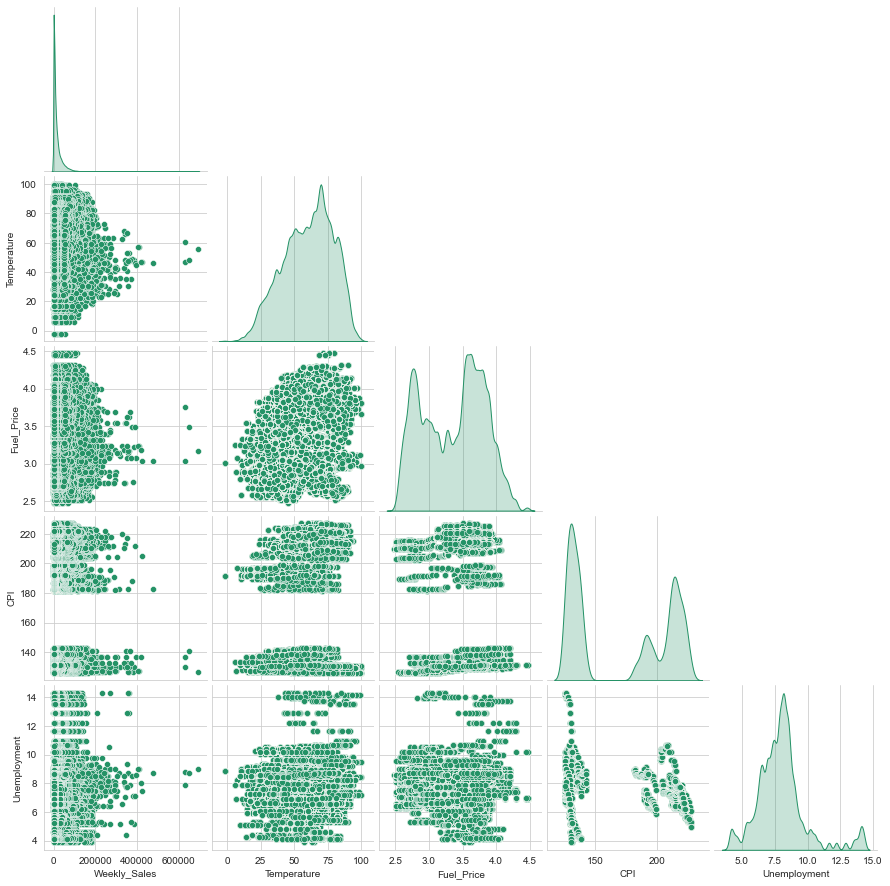

In [18]:
sns.set_palette("summer")
sns.pairplot(train_expanded[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']],
             corner=True,diag_kind="kde");

There is no particular relationship between these features and target variable.

Also, distribution of target variable is highly skewed. That's why, I will not go with linear regression.

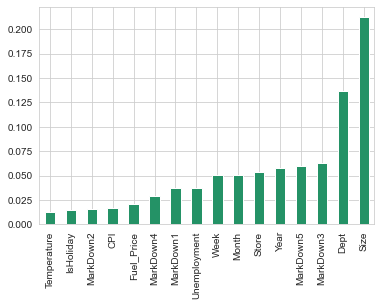

In [19]:
train_expanded.dropna().corr()['Weekly_Sales'].abs().sort_values()[:-1].plot(kind='bar');

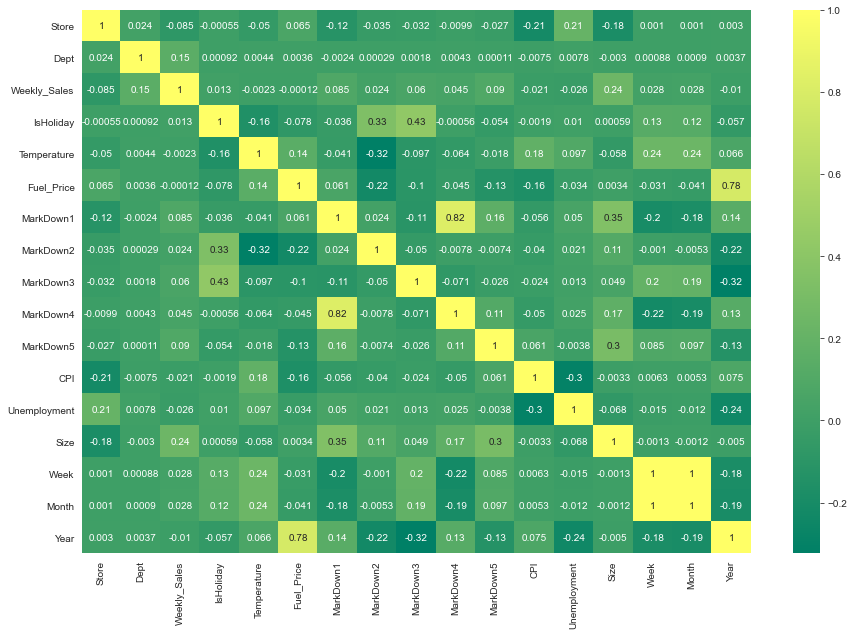

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(train_expanded.corr(),annot=True,cmap='summer');

In above heatmap, correlation between different columns can be checked.

# Loading the relevant libraries 

In [21]:
# importing relevant libraries

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

I will label encode the IsHoliday and Type feature. From EDA, I concluded to drop Year, CPI, unemployment, temperature and fuel price. I am also dropping all the 'markdown' columns.

In [22]:
# preprocessing

def preprocessor(df):
    # label-encoding
    df['IsHoliday'] = df['IsHoliday'].astype('str').map({'True':0,'False':1})
    df.Type = df.Type.map({'A':2,'B':1,'C':0})
    # deleting less important features
    return df.drop(['Date','Year','MarkDown1','MarkDown2','MarkDown4','MarkDown3','MarkDown5','CPI',
             'Unemployment','Temperature','Fuel_Price'],axis=1)

train_preprocessed = preprocessor(train_expanded)
test_preprocessed = preprocessor(test_expanded)

In [23]:
# splitting data into 2 parts

y = train_preprocessed["Weekly_Sales"]
X = train_preprocessed.drop(['Weekly_Sales'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

# function for displaying scores

def score_calc(predictions):
    scores = pd.DataFrame([mean_absolute_error(y_test, predictions)
#                           ,mean_squared_error(y_test, predictions)
                          ,r2_score(y_test, predictions)],columns=['score'],index=['MAE','R2 score'])
    return scores

# function for building model

def run_model(model,name):
    
    name = model()
    name.fit(X_train, y_train)
    preds = name.predict(X_test)
    try:
        feat_imp = name.feature_importances_
        plt.bar(X_train.columns,feat_imp,color='green')
        plt.title('Feature Importance graph')
        plt.xticks(rotation=45)
    except:
        pass
    return score_calc(preds)

In [24]:
train_preprocessed.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Week,Month
0,1,1,24924.50,1,2,151315,5,2
1,1,1,46039.49,0,2,151315,6,2
2,1,1,41595.55,1,2,151315,7,2
3,1,1,19403.54,1,2,151315,8,2
4,1,1,21827.90,1,2,151315,9,3


### Approach 1 : Taking all columns

,score
MAE,1971.102085
R2 score,0.953986


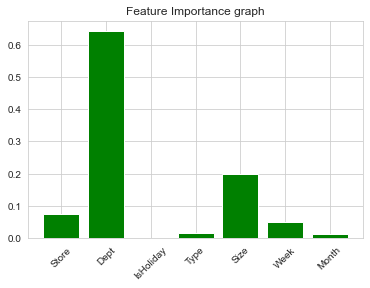

In [25]:
run_model(DecisionTreeRegressor,'dtree')

,score
MAE,1761.800228
R2 score,0.968356


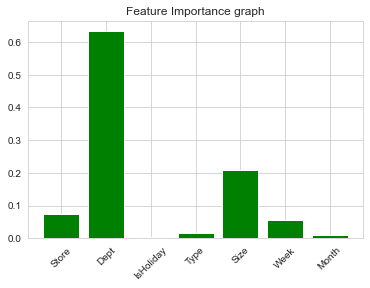

In [26]:
run_model(RandomForestRegressor,'rfc')

,score
MAE,2902.043906
R2 score,0.945758


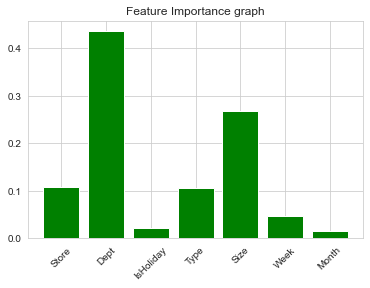

In [27]:
run_model(XGBRegressor,'xgb')

In [28]:
run_model(KNeighborsRegressor,'knn')

,score
MAE,5831.050779
R2 score,0.760129


### Approach 2 : Standardizing the columns

In [29]:
# Tree based models don't need feature scaling as they are not sensitive to variance in the data.

# scaling size column
scaler=StandardScaler()
scaler.fit(train_preprocessed['Size'].values.reshape(-1,1))
X_train['Size'] = scaler.transform(X_train['Size'].values.reshape(-1, 1))
X_test['Size'] = scaler.transform(X_test['Size'].values.reshape(-1, 1))

,score
MAE,1975.355049
R2 score,0.952959


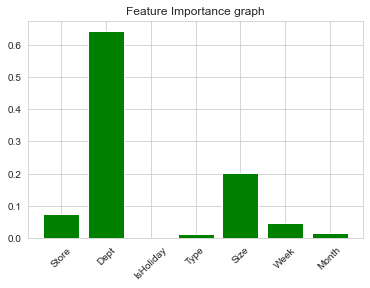

In [30]:
run_model(DecisionTreeRegressor,'dtree')

### Approach 3: Using only Store, Dept and Size columns

In [31]:
X_train = X_train[['Store','Dept','Size']]
X_test = X_test[['Store','Dept','Size']]

,score
MAE,2661.648621
R2 score,0.905231


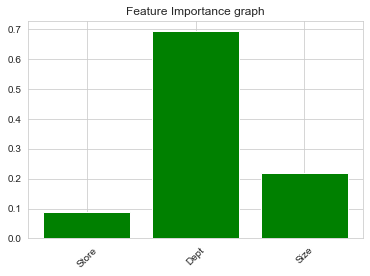

In [32]:
run_model(DecisionTreeRegressor,'dtree')

In [33]:
# I tried one hot encoding week feature but score did not improve so I dropped the idea.

# dummies=pd.get_dummies(train_preprocessed.Week.astype(str),drop_first=True,prefix='week')
# dum_week = pd.concat([train_preprocessed,dummies],axis=1)
# dum_week.drop('Week',axis=1,inplace=True)

# Cross-validation

In [34]:
# option A
from sklearn.model_selection import cross_val_score
score = cross_val_score(RandomForestRegressor(), X, y, cv=4)
print(f"Average 4-Fold CV Score: {score.mean().round(4)}")

Average 4-Fold CV Score: 0.6927


#### Hyper Parameter Tuning

In [35]:
random_grid = {'n_estimators': [50,60,70],
               'max_features': [3,4],
               'max_depth': [25,30,35],
               'min_samples_split': [3,4],
              'min_samples_leaf':[1,2]}

rf_grid = RandomizedSearchCV(RandomForestRegressor(),
                        random_grid,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True)

rf_grid.fit(X,y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  4.3min finished


0.7811404446551148
{'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 30}


So, cv scored increased after hyper-parameter tuning.

In [36]:
# option B - cross-validation using kfold

predictor_train_scale = train_preprocessed.drop('Weekly_Sales',axis=1)
predictor_test_scale = test_preprocessed
target_train = train_preprocessed.Weekly_Sales

kf=KFold(n_splits=4,shuffle=True)

preds_3   = list()
y_pred_3  = []
r2_score_ = []
mae=[]

# Applying model on each fold and calculating mean of score
    for i,(train_idx,val_idx) in enumerate(kf.split(predictor_train_scale)):    
    
    X_train, y_train = predictor_train_scale.iloc[train_idx,:], target_train.iloc[train_idx]    
    X_val, y_val = predictor_train_scale.iloc[val_idx, :], target_train.iloc[val_idx]
   
    print('\nFold: {}\n'.format(i+1))
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    r2 = r2_score(y_val,rf.predict(X_val))
    mae_ = mean_absolute_error(y_val,rf.predict(X_val))
    r2_score_.append(r2)
    mae.append(mae_)
    preds_3.append(rf.predict(predictor_test_scale[predictor_test_scale.columns]))
    
y_pred_final_3 = np.mean(preds_3,axis=0)    

print('R2 - CV Score: {}'.format((sum(r2_score_)/4)),'\n')
print('MAE Score: {}'.format((sum(mae)/4)),'\n')
print("Score : ",r2_score_)


Fold: 1


Fold: 2


Fold: 3


Fold: 4

R2 - CV Score: 0.9690127147035557 

MAE Score: 1767.9028878563809 

Score :  [0.9698665949347756, 0.9710541212095556, 0.965208426389798, 0.9699217162800935]


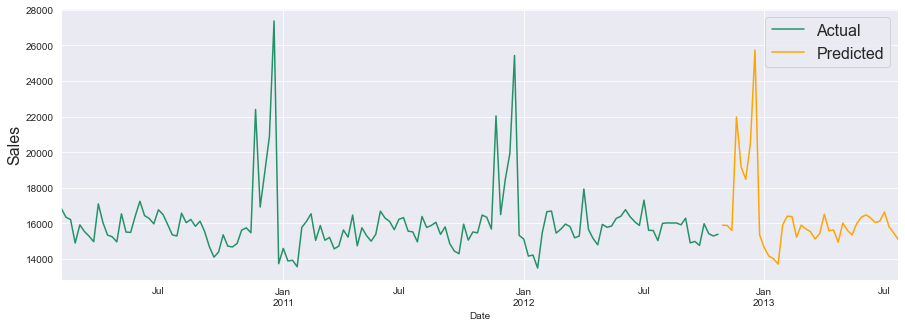

In [37]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,5))
test_expanded['Weekly_Sales'] = y_pred_final_3
train_expanded.groupby('Date')['Weekly_Sales'].mean().plot()
test_expanded.groupby('Date')['Weekly_Sales'].mean().plot(color='orange')
plt.legend(['Actual', 'Predicted'], loc='best', fontsize=16)
plt.ylabel('Sales', fontsize=16);

# Making Final Predictions

In [38]:
submission = pd.read_csv('sampleSubmission.csv.zip')
submission['Weekly_Sales'] = y_pred_final_3
submission.to_csv('results_rf_cv_tuned.csv',index=False)